# Validation Notebook using Iwabuchi et al. 2009

- see: Iwabuchi, H., & Suzuki, T. (2009). Fast and accurate radiance calculations using truncation approximation for anisotropic scattering phase functions. Journal of Quantitative Spectroscopy and Radiative Transfer, 110(17), 1926-1939.

In [26]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import numpy as np
from scipy.integrate import simpson, fixed_quad, trapezoid
from pytrunc.phase import calc_moments
from pytrunc.truncation import delta_m_phase_approx, gt_phase_approx

import matplotlib.pyplot as plt
import xarray as xr

## Truncation approximation for the anisotropic phase function

### Get realistic water cloud phase function from mie calculation

wav=498.6099853515625 nm ; reff=8.0 um


(0.0, 180.0)

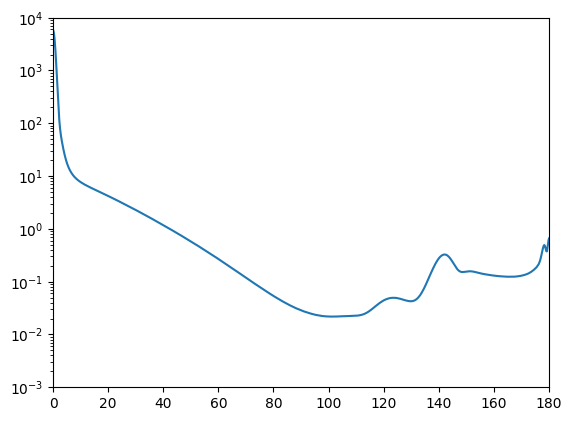

In [33]:
# wc available in smartg auxdata: https://github.com/hygeos/smartg
# Follow smartg README to download auxdata, 
# then create environemnt variable 'SMARTG_DIR_AUXDATA' where auxdata have been downloaded
wc_path = Path(os.environ['SMARTG_DIR_AUXDATA']) / Path('clouds/wc_sol.nc')
ds = xr.open_dataset(wc_path)
# in the paper (Iwabuchi et al. 2009) wl = 500 nm and reff = 8 um
iwav = 49 # iwabuchi
ireff = 3 # iwabuchi
print(f"wav={ds.wav.values[iwav]} nm ; reff={ds.reff.values[ireff]} um")
theta = ds['theta'].values
pha_exact = ds["phase"][ireff,iwav,0,:].values

theta = np.linspace(0., 180., 18001)
pha_exact = np.interp(theta, ds.theta.values, pha_exact)

plt.plot(theta, pha_exact)
plt.yscale('log')
plt.ylim(ymin=1e-3, ymax=1e4)
plt.xlim(xmin=0, xmax=180)

### Plot exact and approximated phase functions
 - Reproduce Fig.1a

/home/Mustapha/Documents/HYGEOS/pytrunc/pytrunc/truncation.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  


integral(P_exact)= 1.999854160177657
integral(P_approx)= 2.0000000816919403
f = 0.4331838852421042


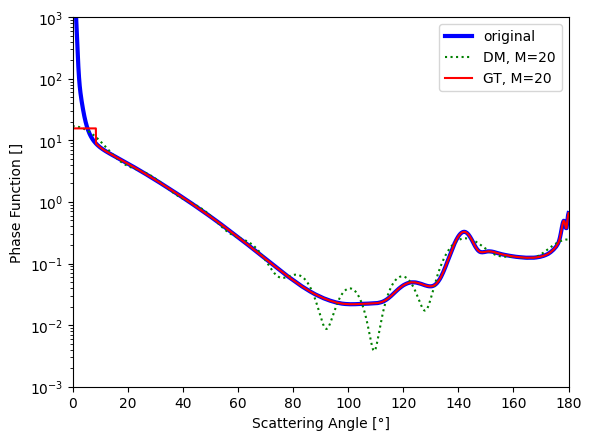

In [40]:
m_max = 20
pha_approx, f, pha_star, chi_star = delta_m_phase_approx(pha_exact, theta, m_max)
pha_approx_gt, f_gt, pha_star_gt = gt_phase_approx(pha_exact, theta, f)
plt.plot(theta, pha_exact, 'b', lw=3, label='original')
plt.plot(theta, pha_approx, 'g:', label=f'DM, M={m_max}')
plt.plot(theta, pha_approx_gt, 'r', label=f'GT, M={m_max}')
plt.yscale('log')
plt.ylim(ymin=1e-3, ymax=1e3)
plt.xlim(xmin=0, xmax=180)
plt.legend()
plt.ylabel("Phase Function []")
plt.xlabel("Scattering Angle [°]")

mu = np.cos(np.deg2rad(theta))
idmu = np.argsort(mu)
print("integral(P_exact)=", trapezoid(pha_exact[idmu], mu[idmu]))
print("integral(P_approx)=", trapezoid(pha_approx[idmu], mu[idmu]))
print("f =",f)

### Zoom of previous plot
- Fig.1b

Text(0.5, 0, 'Scattering Angle [°]')

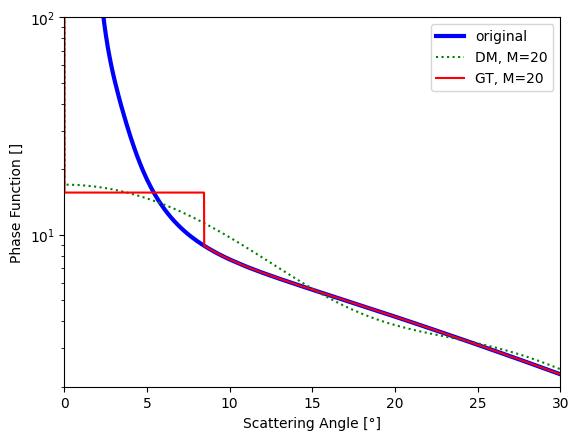

In [35]:
plt.plot(theta, pha_exact, 'b', lw=3, label='original')
plt.plot(theta, pha_approx, 'g:', label=f'DM, M={m_max}')
plt.plot(theta, pha_approx_gt, 'r', label=f'GT, M={m_max}')
plt.yscale('log')
plt.ylim(ymin=2, ymax=100)
plt.xlim(xmin=0, xmax=30)
plt.legend()
plt.ylabel("Phase Function []")
plt.xlabel("Scattering Angle [°]")

### Plot exact and approximated phase moments
- Fig.2a

Text(0.5, 0, 'Expansion order []')

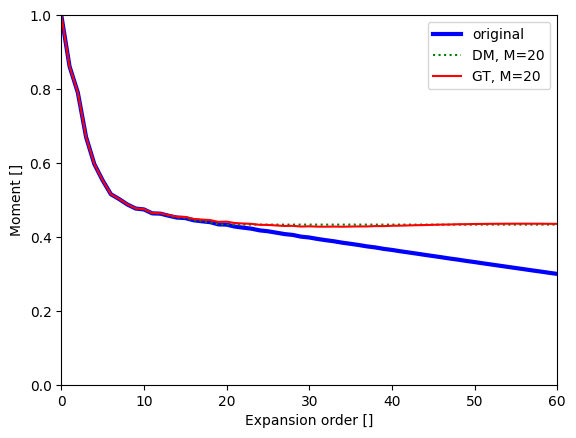

In [36]:
n_expan = 60
chi_exact = calc_moments(phase=pha_exact, theta=theta, m_max=n_expan, normalize=True)
chi_star_approx = calc_moments(phase=pha_star, theta=theta, m_max=n_expan, normalize=True)
chi_approx = f + (1-f) * chi_star_approx
chi_star_approx_gt = calc_moments(phase=pha_star_gt, theta=theta, m_max=n_expan, normalize=True)
chi_approx_gt = f + (1-f) * chi_star_approx_gt

exp_order = np.arange(61)
plt.plot(chi_exact, 'b', lw=3, label='original')
plt.plot(chi_approx, 'g:', label=f'DM, M={m_max}')
plt.plot(chi_approx_gt, 'r', label=f'GT, M={m_max}')
plt.xlim(xmin=0, xmax = 60)
plt.ylim(ymin=0, ymax=1)
plt.legend()
plt.ylabel("Moment []")
plt.xlabel("Expansion order []")

### Plot moment ratio
- Fig.2b

Text(0.5, 0, 'Expansion order []')

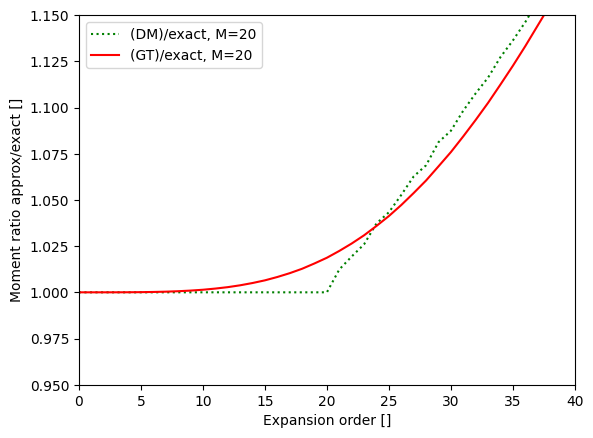

In [37]:
exp_order = np.arange(61)
plt.plot(chi_approx/chi_exact, 'g:', label=f'(DM)/exact, M={m_max}')
plt.plot(chi_approx_gt/chi_exact, 'r', label=f'(GT)/exact, M={m_max}')
plt.xlim(xmin=0, xmax = 40)
plt.ylim(ymin=0.95, ymax=1.15)
plt.legend()
plt.ylabel("Moment ratio approx/exact []")
plt.xlabel("Expansion order []")